In [87]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
from torchvision.utils import make_grid
# import warnings
# warnings.filterwarnings("ignore")
# %matplotlib inline
# plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler


import nibabel

In [88]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [89]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72,  77,
        80,  85, 251, 252, 253, 254, 255]

In [90]:
len(available_segments)

46

In [91]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = True, rotation = True, translation = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)

        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        
        im = Image.fromarray(image[0])
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))/255
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((46,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        sample = {'x':im,'y':target_label} 
        return sample

In [92]:
file_names = pd.read_csv("all_complete_path.csv")

In [93]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [94]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [95]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [96]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:5000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [97]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=12,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [108]:
inputs = next(iter(dataloader['train']))

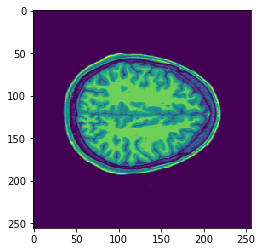

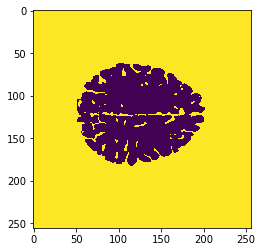

In [109]:
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

In [115]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [ ]:
[  0,   2,   3,   4,   5,   7,   8,  10,
 
  11,  12,  13,  14,  15,  16,  17,  18,
 
  24,  26,  28,  30,  31,  41,  42,  43,
 
  44,  46,  47,  49,  50,  51,  52,  53,
 
  54,  58,  60,  62,  63,  72,  77,  80,
 
  85, 251, 252, 253, 254, 255 ]

In [129]:
col1 = ["Unknown","Left-Caudate","CSF","Right-Inf-Lat-Vent","Right-Amygdala","Optic-Chiasm"]
col2 = ["Left-Cerebral-White-Matter", "Left-Putamen", "Left-Accumbens-area", "Right-Cerebellum-White-Matter", "Right-Accumbens-area", "Iris"]
col3 = ["Left-Cerebral-Cortex", "Left-Pallidum", "Left-VentralDC", "Right-Cerebellum-Cortex", "Right-VentralDC", "CC_Mid_Posterior"]
col4 = ["Left-Lateral-Ventricle", "3rd-Ventricle", "Left-vessel", "Right-Thalamus-Proper", "Right-vessel", "CC_Central"]
col5 = ["Left-Inf-Lat-Vent", "4th-Ventricle", "Left-choroid-plexus", "Right-Caudate", "Right-choroid-plexus", "CC_Mid_Anterior"]
col6 = ["Left-Cerebellum-White-Matter","Brain-Stem","Right-Cerebral-White-Matter", "Right-Putamen", "5th-Ventricle", "CC_Anterior"]

col7 = ["Left-Cerebellum-Cortex", "Left-Hippocampus", "Right-Cerebral-Cortex", "Right-Pallidum", "WM-hypointensities",""]

col8 = ["Left-Thalamus-Proper", "Left-Amygdala", "Right-Lateral-Ventricle", "Right-Hippocampus","non-WM-hypointensities",""]

In [131]:
df_segments = pd.DataFrame()
df_segments["col1"] = col1
df_segments["col2"] = col2
df_segments["col3"] = col3
df_segments["col4"] = col4
df_segments["col5"] = col5
df_segments["col6"] = col6
df_segments["col7"] = col7
df_segments["col8"] = col8
df_segments

,col1,col2,col3,col4,col5,col6,col7,col8
0,Unknown,Left-Cerebral-White-Matter,Left-Cerebral-Cortex,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper
1,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,Brain-Stem,Left-Hippocampus,Left-Amygdala
2,CSF,Left-Accumbens-area,Left-VentralDC,Left-vessel,Left-choroid-plexus,Right-Cerebral-White-Matter,Right-Cerebral-Cortex,Right-Lateral-Ventricle
3,Right-Inf-Lat-Vent,Right-Cerebellum-White-Matter,Right-Cerebellum-Cortex,Right-Thalamus-Proper,Right-Caudate,Right-Putamen,Right-Pallidum,Right-Hippocampus
4,Right-Amygdala,Right-Accumbens-area,Right-VentralDC,Right-vessel,Right-choroid-plexus,5th-Ventricle,WM-hypointensities,non-WM-hypointensities
5,Optic-Chiasm,Iris,CC_Mid_Posterior,CC_Central,CC_Mid_Anterior,CC_Anterior,,


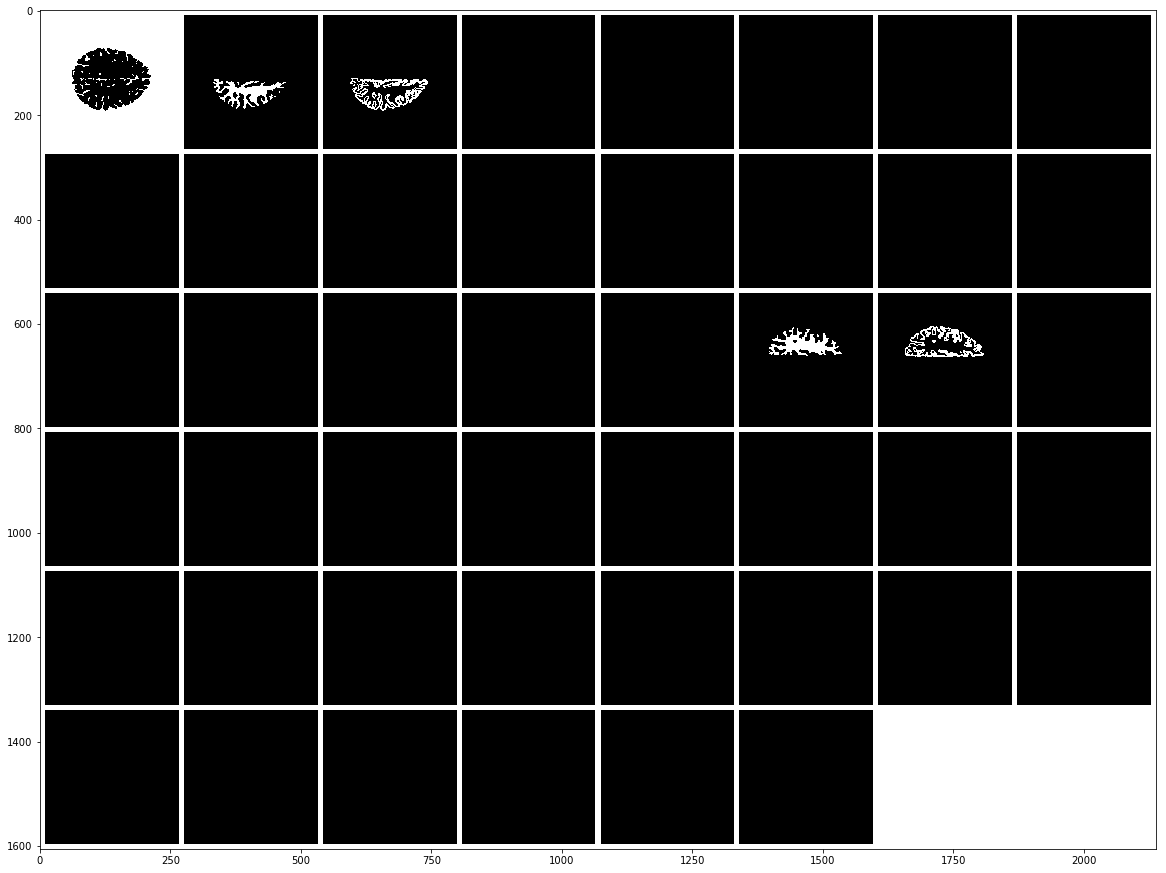

In [118]:
abc = inputs['y'][1,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

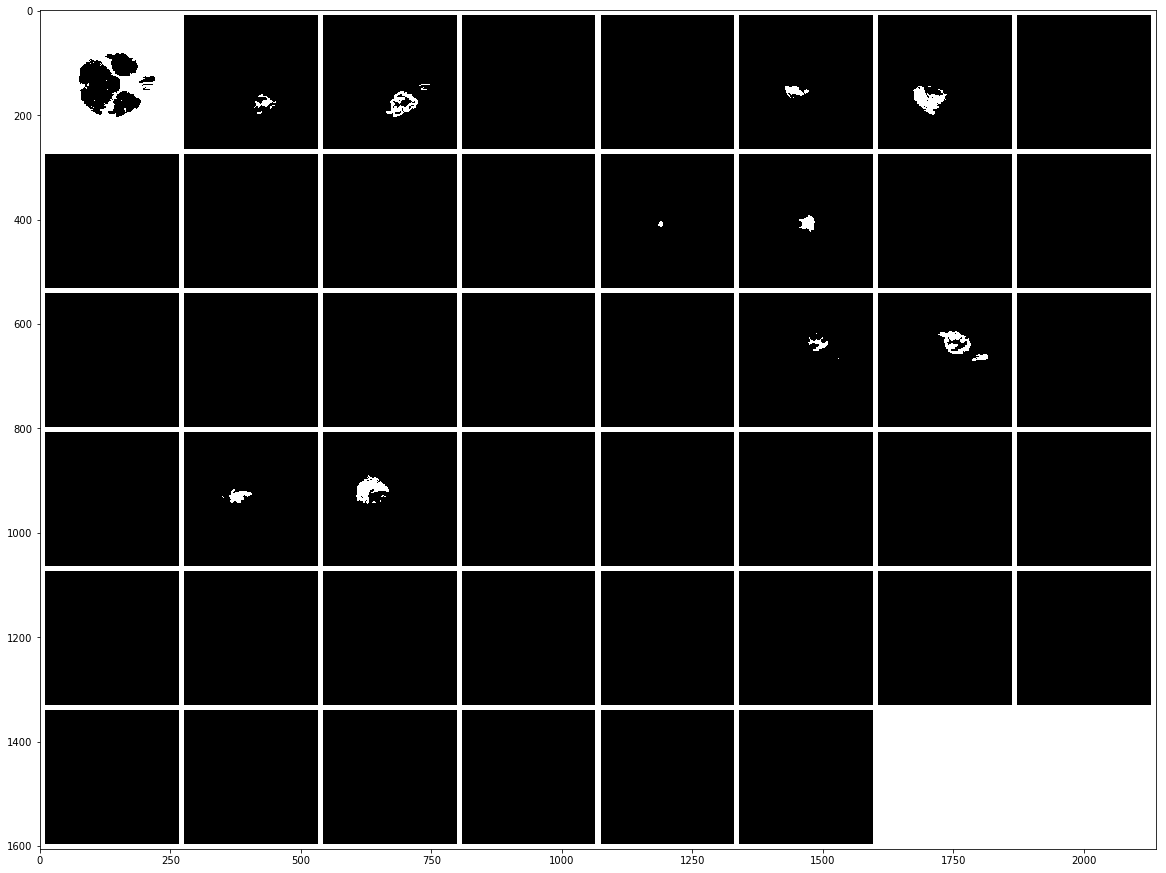

In [119]:
abc = inputs['y'][2,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

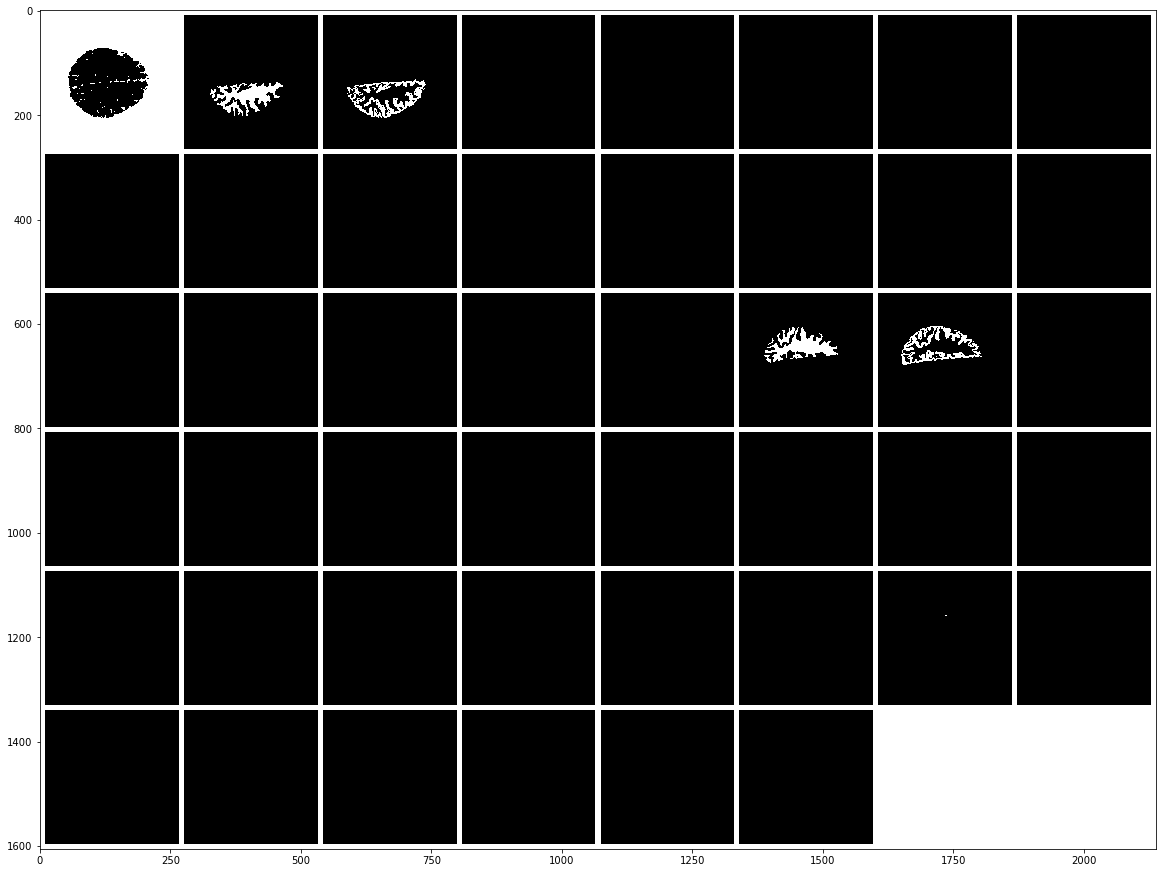

In [121]:
abc = inputs['y'][10,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

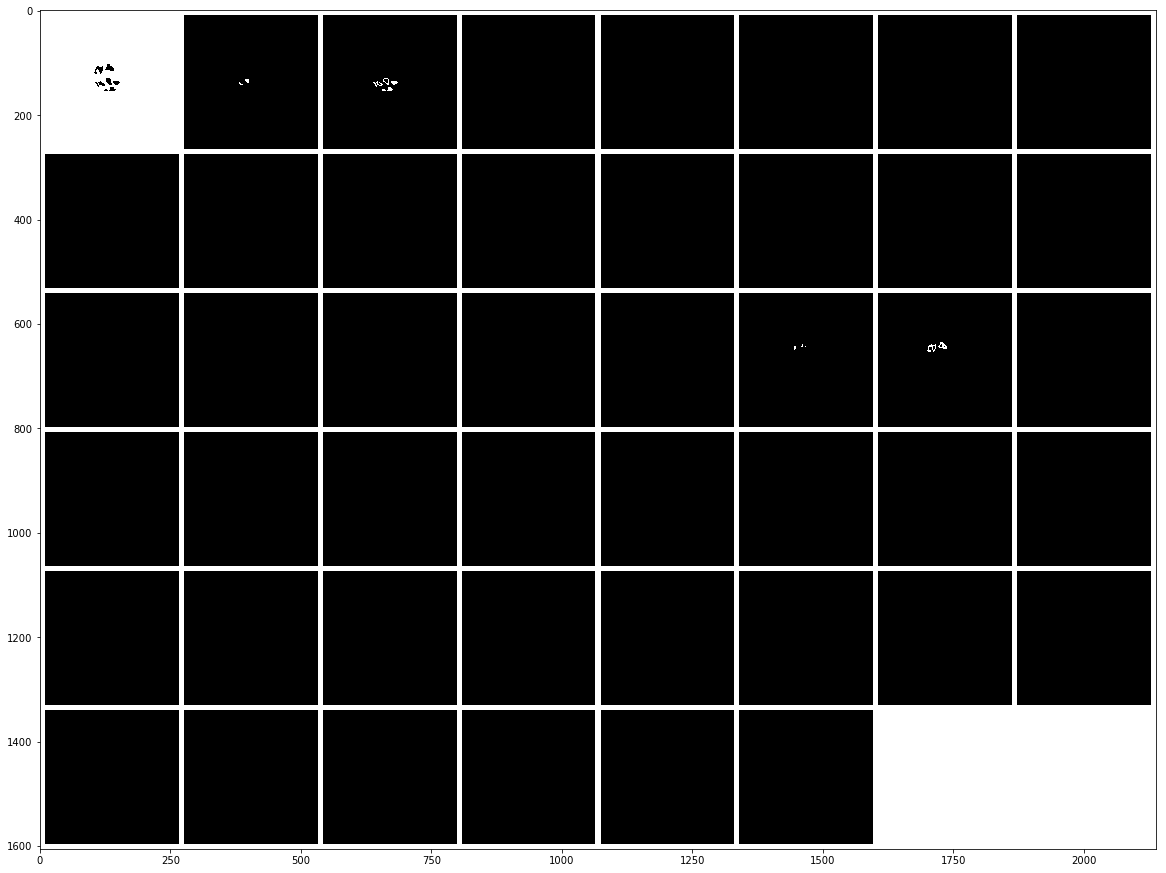

In [124]:
abc = inputs['y'][8,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

In [142]:
inputs = next(iter(dataloader['train']))

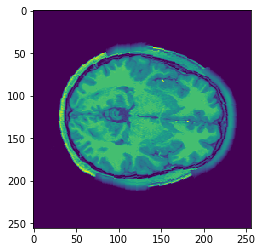

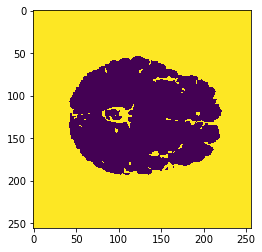

In [143]:
plt.imshow(inputs['x'][1,0,:,:].numpy())
plt.show()
plt.imshow(inputs['y'][1,0,:,:].numpy())
plt.show()

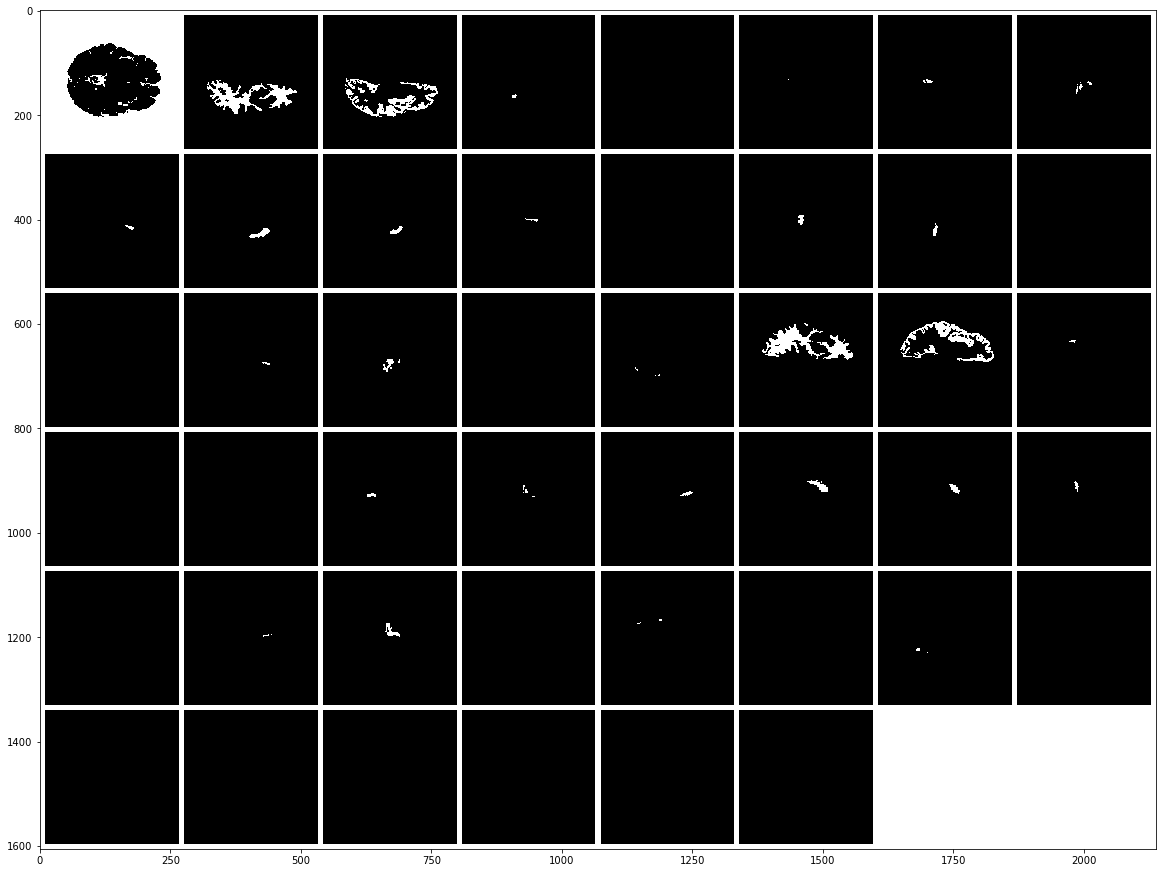

In [144]:
abc = inputs['y'][1,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

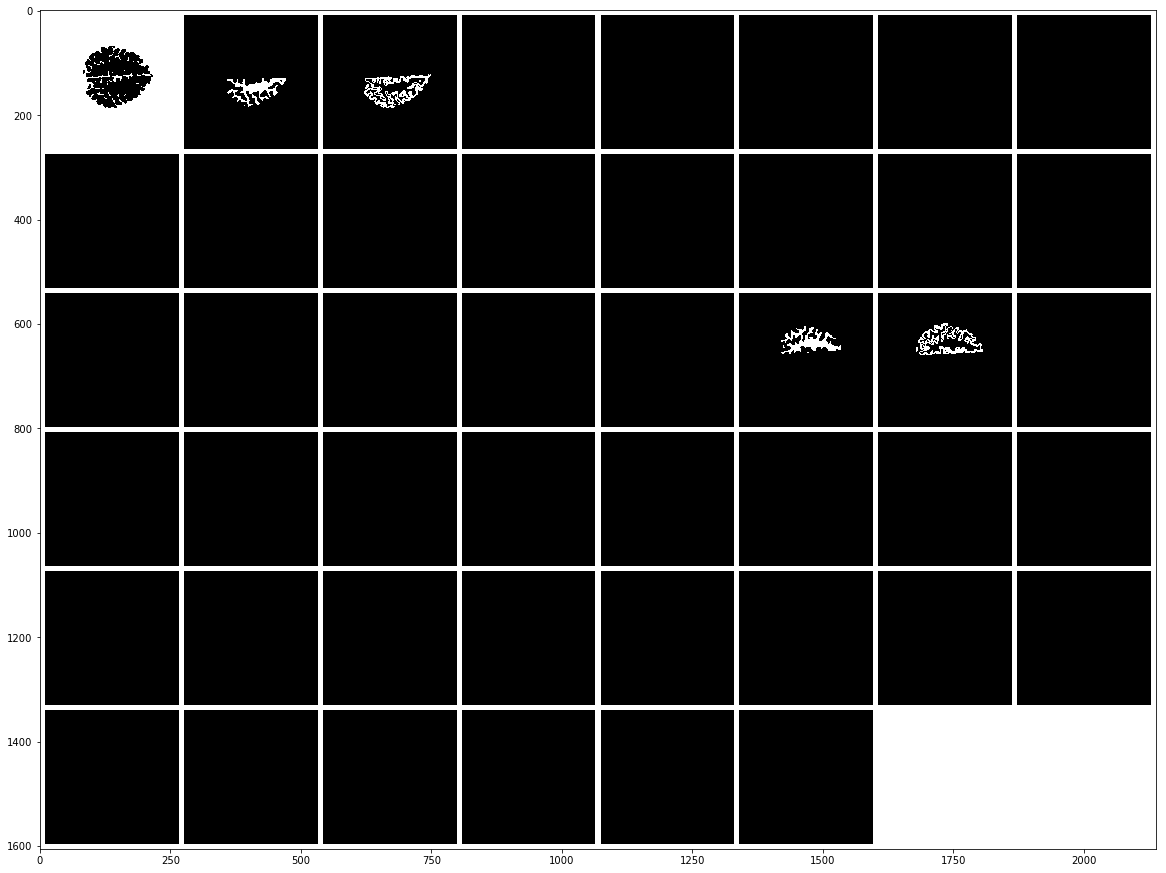

In [145]:
abc = inputs['y'][2,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

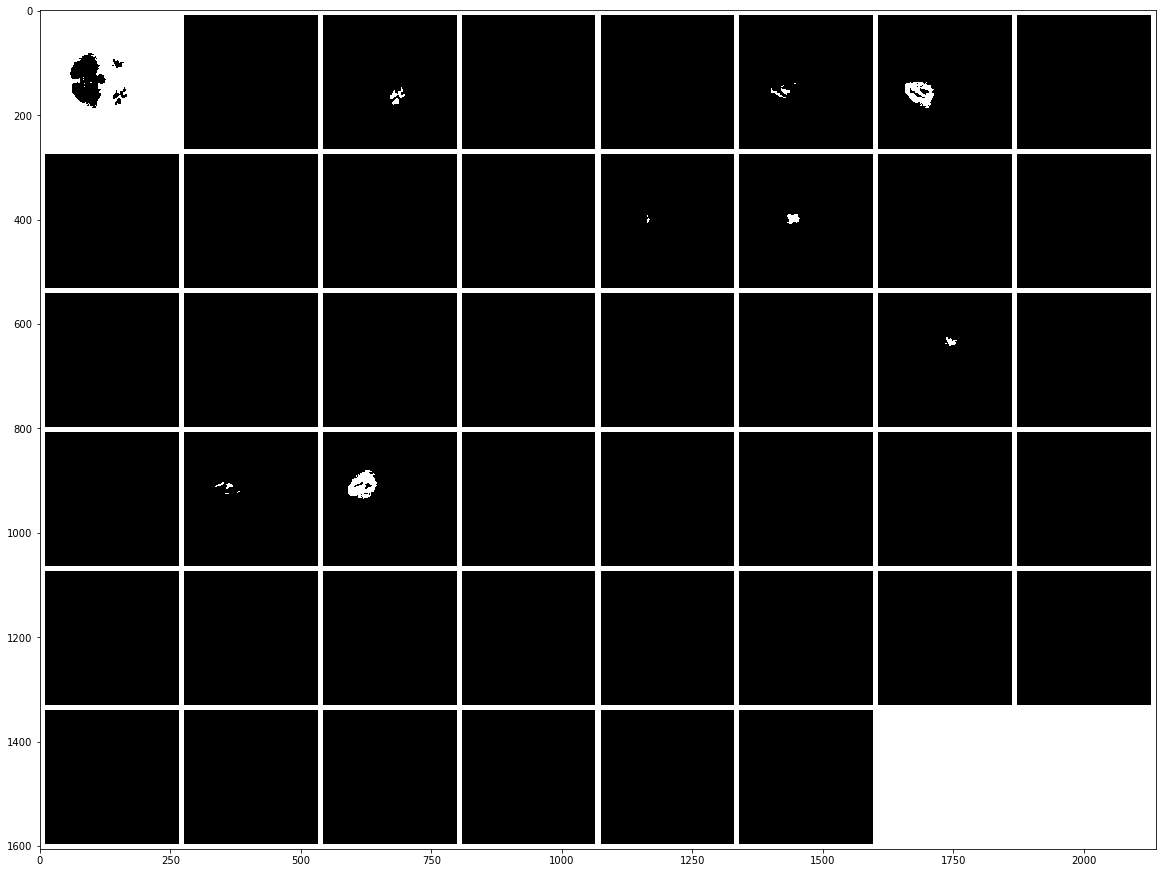

In [146]:
abc = inputs['y'][3,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

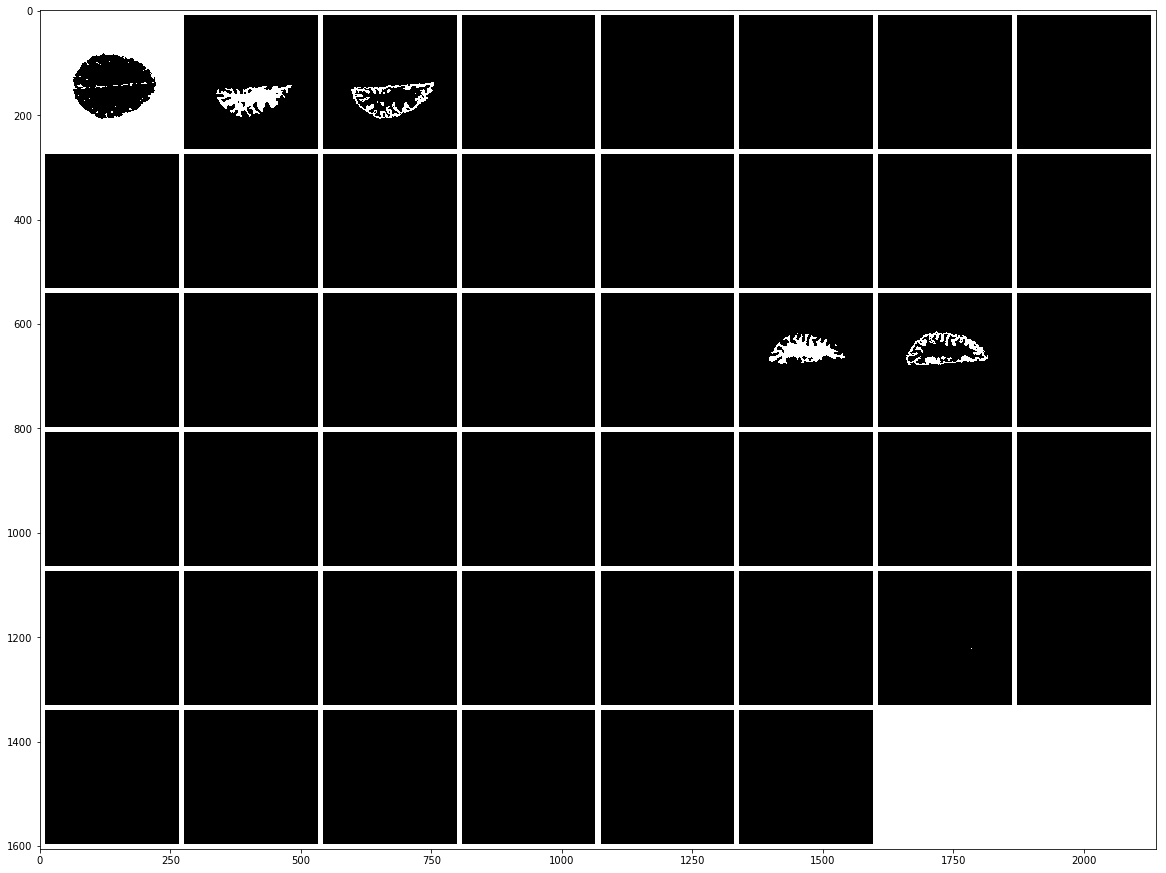

In [149]:
abc = inputs['y'][8,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

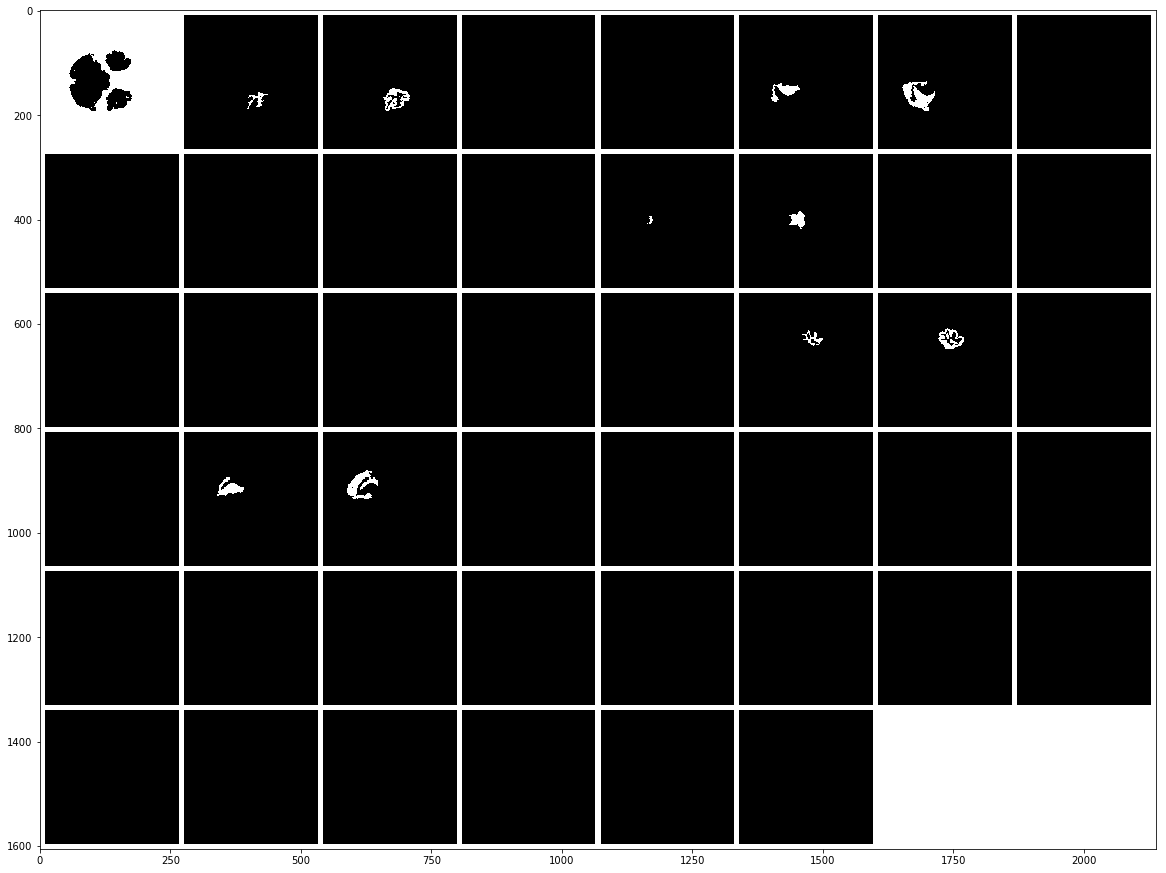

In [155]:
inputs = next(iter(dataloader['train']))
abc = inputs['y'][1,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

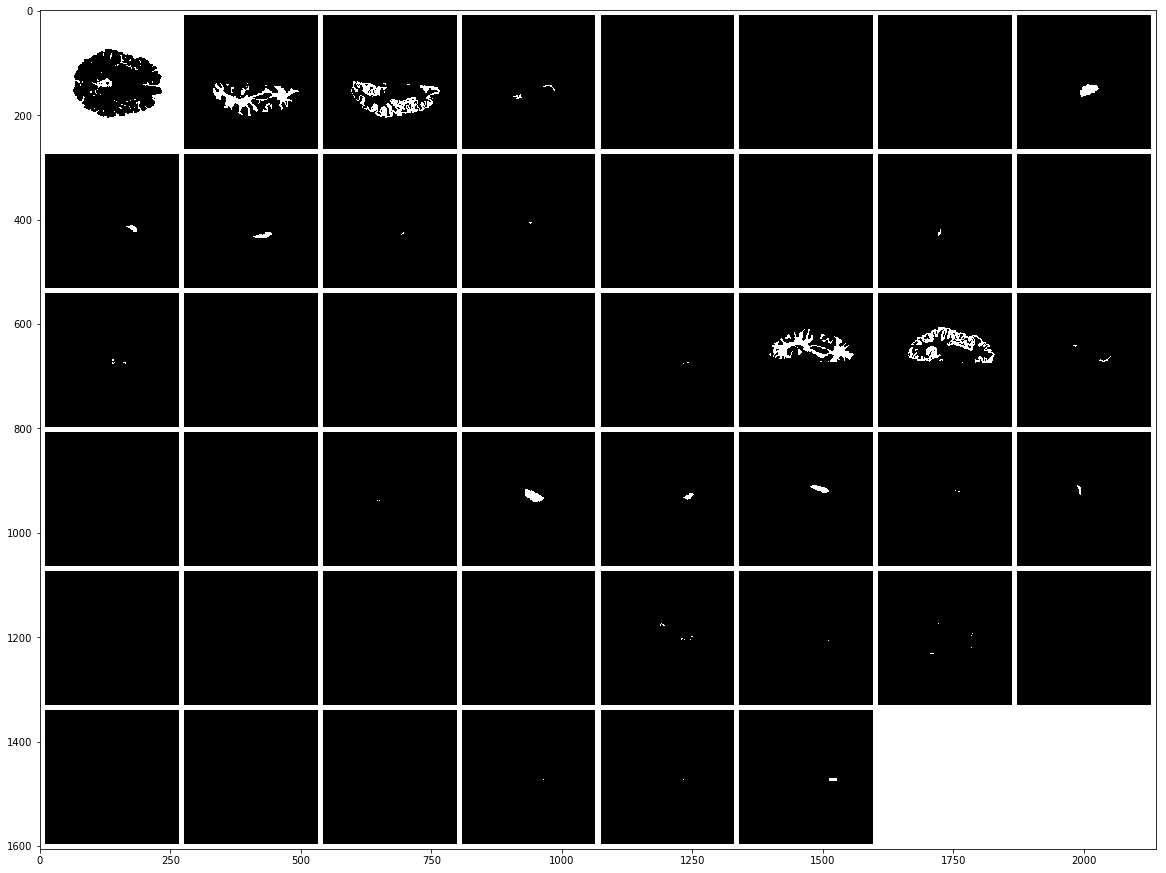

In [157]:
abc = inputs['y'][3,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

In [158]:
segment_count = pd.read_csv("/cbi/hcp/hcp_seg/git/BrainSeg/segment_counts.csv")

In [159]:
segment_count

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,15796322,0,174185,209716,2501,96,0,11943,47344,0,...,0,0,0,0,0,0,0,0,0,0
1,15589807,0,232298,239061,4605,116,0,14367,49428,0,...,0,0,0,0,0,0,0,0,0,0
2,15500836,0,215074,282182,11154,151,0,16542,61411,0,...,0,0,0,0,0,0,0,0,0,0
3,15478174,0,243786,274994,3107,104,0,15987,55193,0,...,0,0,0,0,0,0,0,0,0,0
4,15386781,0,271258,295296,6119,36,0,14019,50783,0,...,0,0,0,0,0,0,0,0,0,0
5,15392775,0,277296,280714,3896,154,0,16713,59198,0,...,0,0,0,0,0,0,0,0,0,0
6,15599558,0,230183,237454,3671,196,0,13941,54603,0,...,0,0,0,0,0,0,0,0,0,0
7,15367603,0,264748,292057,4256,429,0,15791,65652,0,...,0,0,0,0,0,0,0,0,0,0
8,15333367,0,253563,328614,6853,80,0,15261,62887,0,...,0,0,0,0,0,0,0,0,0,0
9,15535678,0,222515,262822,6730,303,0,15828,58655,0,...,0,0,0,0,0,0,0,0,0,0


In [161]:
new_one = segment_count.astype(bool).sum(axis=0)

In [164]:
names_of_segment = ["Unknown","Left-Cerebral-White-Matter","Left-Cerebral-Cortex","Left-Lateral-Ventricle","Left-Inf-Lat-Vent","Left-Cerebellum-White-Matter",
"Left-Cerebellum-Cortex", "Left-Thalamus-Proper", "Left-Caudate", "Left-Putamen","Left-Pallidum","3rd-Ventricle","4th-Ventricle",
"Brain-Stem", "Left-Hippocampus", "Left-Amygdala", "CSF","Left-Accumbens-area", "Left-VentralDC", "Left-vessel","Left-choroid-plexus",
"Right-Cerebral-White-Matter","Right-Cerebral-Cortex","Right-Lateral-Ventricle","Right-Inf-Lat-Vent","Right-Cerebellum-White-Matter",
"Right-Cerebellum-Cortex","Right-Thalamus-Proper","Right-Caudate","Right-Putamen","Right-Pallidum","Right-Hippocampus",
"Right-Amygdala","Right-Accumbens-area","Right-VentralDC","Right-vessel","Right-choroid-plexus","5th-Ventricle",
"WM-hypointensities","non-WM-hypointensities","Optic-Chiasm","Iris","CC_Mid_Posterior","CC_Central","CC_Mid_Anterior",
"CC_Anterior"]

In [165]:
number_of_subjects = pd.DataFrame()

In [167]:
number_of_subjects["segment"] = names_of_segment
number_of_subjects["number of subjects having the segment"] = list(new_one[new_one!=0])

In [168]:
number_of_subjects

,segment,number of subjects having the segment
0,Unknown,1113
1,Left-Cerebral-White-Matter,1113
2,Left-Cerebral-Cortex,1113
3,Left-Lateral-Ventricle,1113
4,Left-Inf-Lat-Vent,1113
5,Left-Cerebellum-White-Matter,1113
6,Left-Cerebellum-Cortex,1113
7,Left-Thalamus-Proper,1113
8,Left-Caudate,1113
9,Left-Putamen,1113


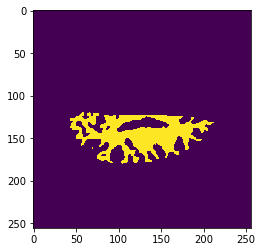

In [174]:
plt.imshow(inputs['y'][8,0,:,:])
plt.imshow(inputs['y'][8,1,:,:])
plt.show()

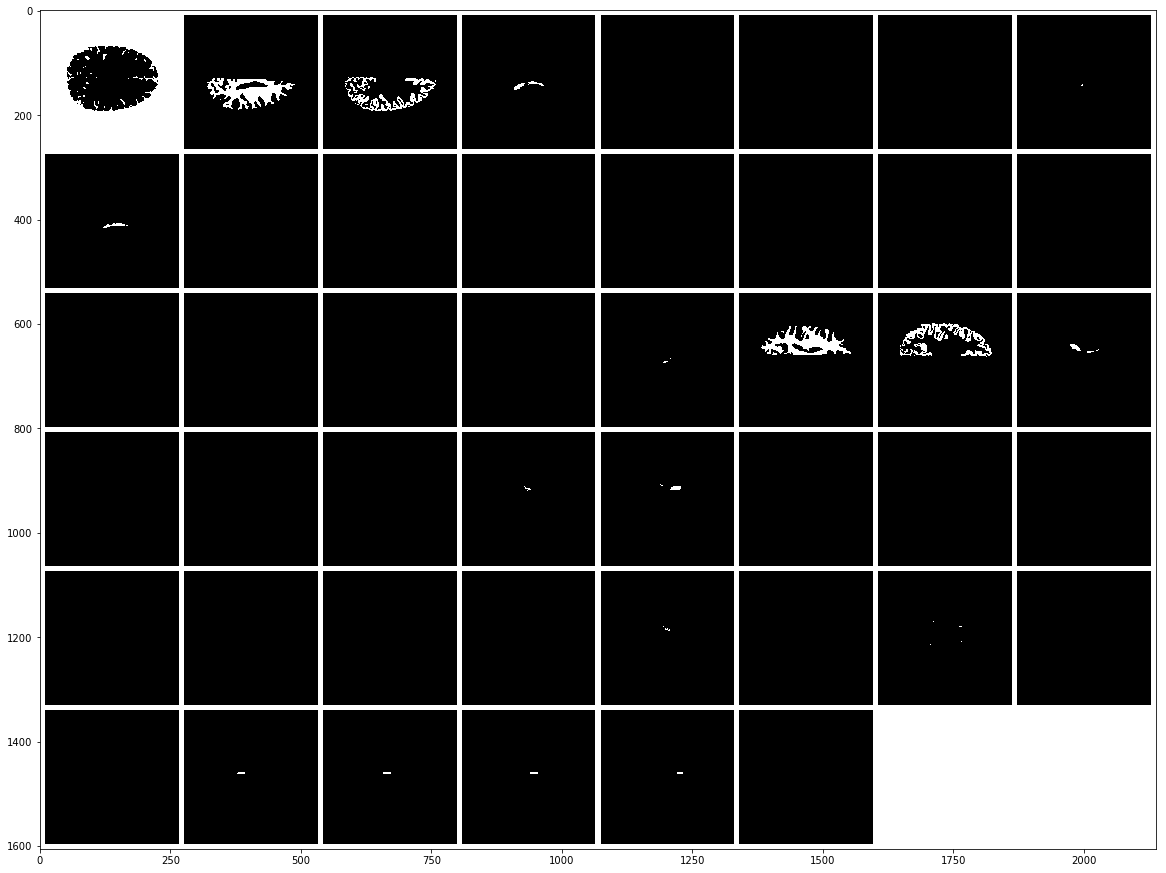

In [172]:
abc = inputs['y'][8,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

## Random Image

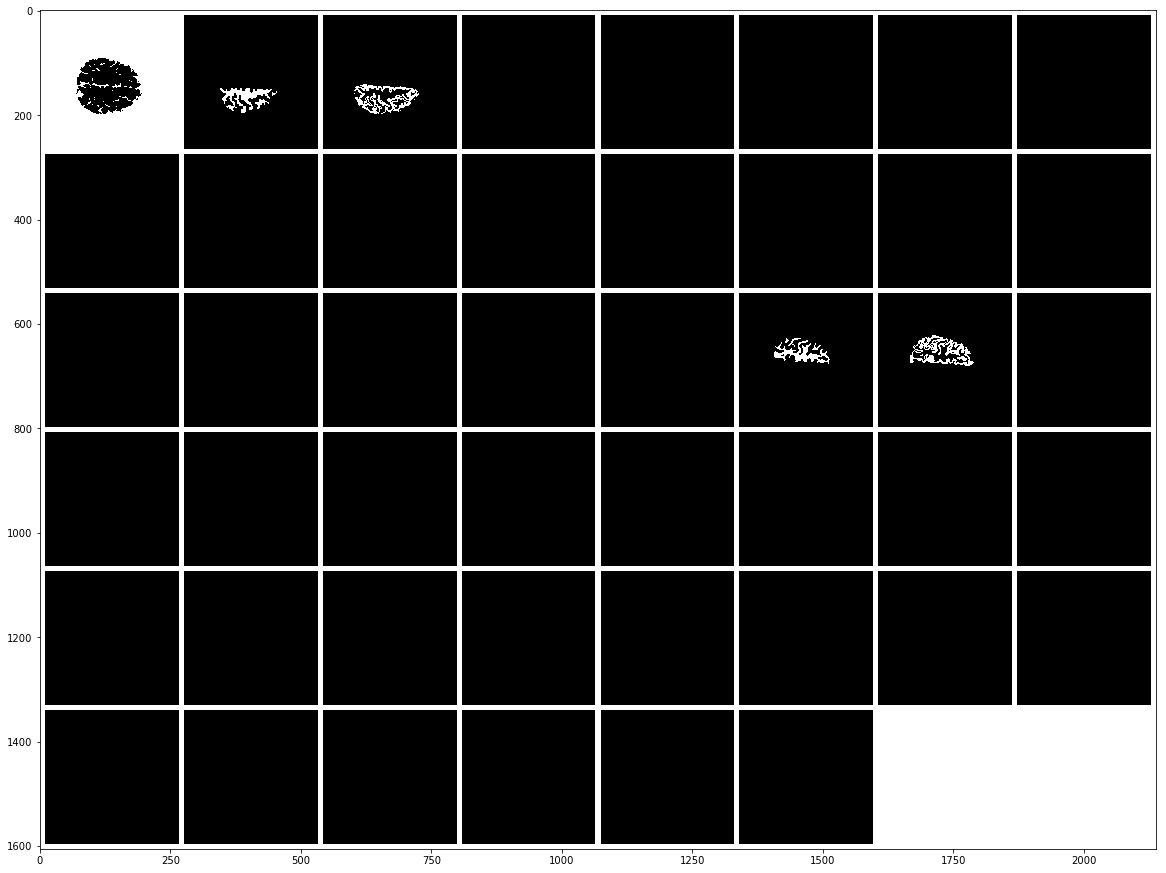

In [177]:
abc = inputs['y'][1,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

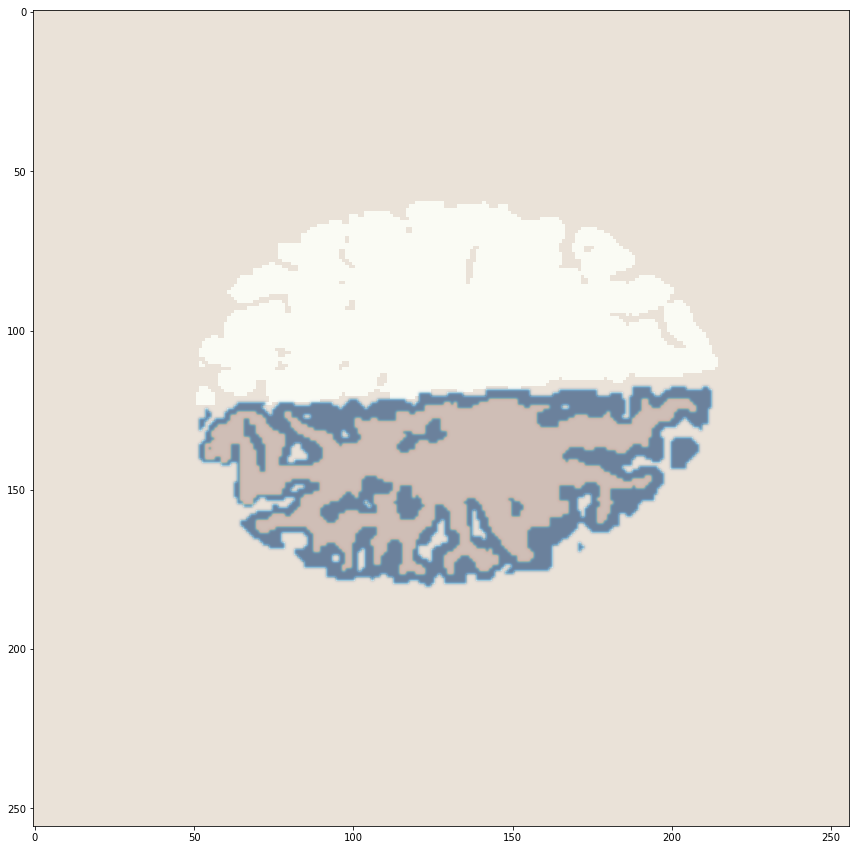

In [180]:
#inputs = next(iter(dataloader['train']))
plt.figure(figsize = (15,15))


plt.imshow(inputs['y'][1,0,:,:].numpy(), cmap=plt.cm.Oranges, alpha = 1, interpolation='nearest')
plt.imshow(inputs['y'][1,1,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.7, interpolation='gaussian')
plt.imshow(inputs['y'][1,2,:,:].numpy(), cmap=plt.cm.Blues, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,3,:,:].numpy(), cmap=plt.cm.Greens, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,7,:,:].numpy(), cmap=plt.cm.Reds, alpha=.6, interpolation='gaussian')

# plt.imshow(inputs['y'][1,8,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,9,:,:].numpy(), cmap=plt.cm.YlOrRd, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,10,:,:].numpy(), cmap=plt.cm.OrRd, alpha=.6, interpolation='gaussian')

plt.show()




## Random Image

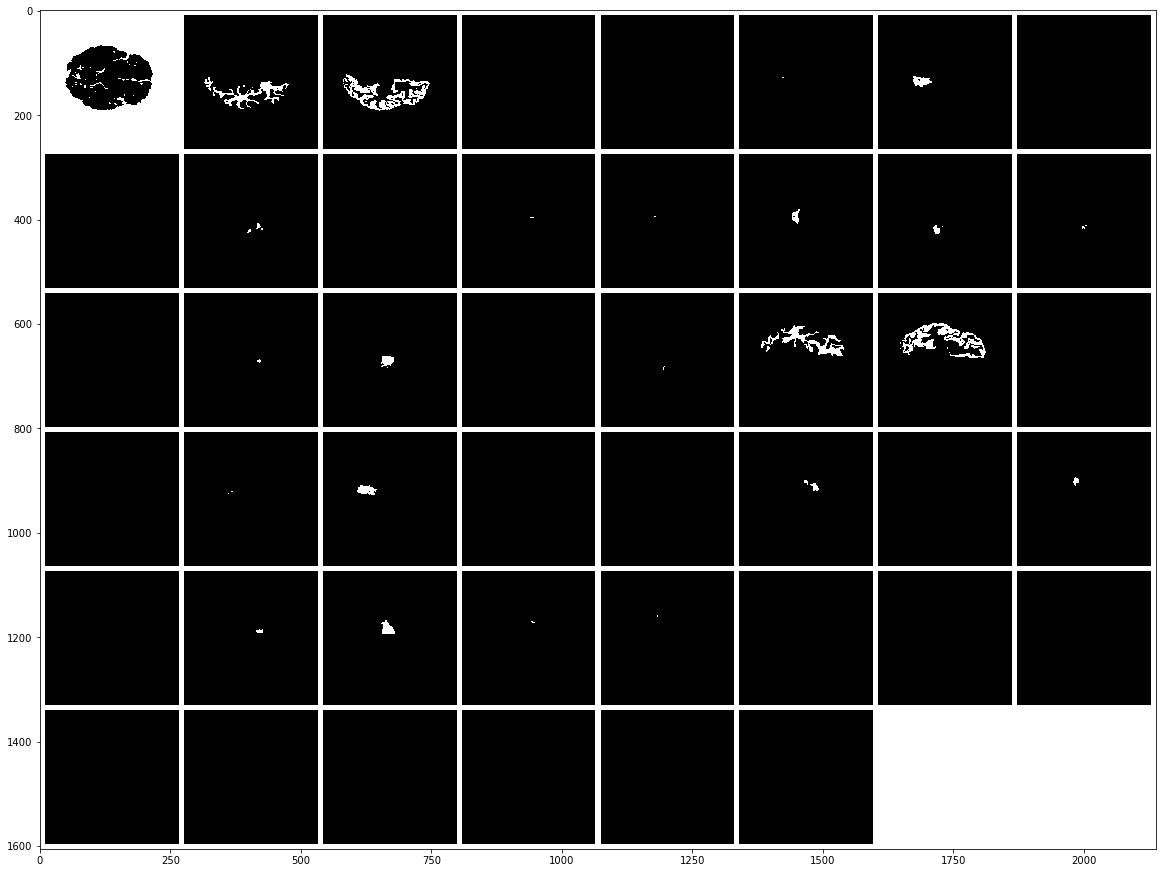

In [208]:
inputs = next(iter(dataloader['train']))
abc = inputs['y'][1,:,:,:]
bcd = abc.resize(46,1,256,256)
show(make_grid(bcd,padding=10,pad_value=1))

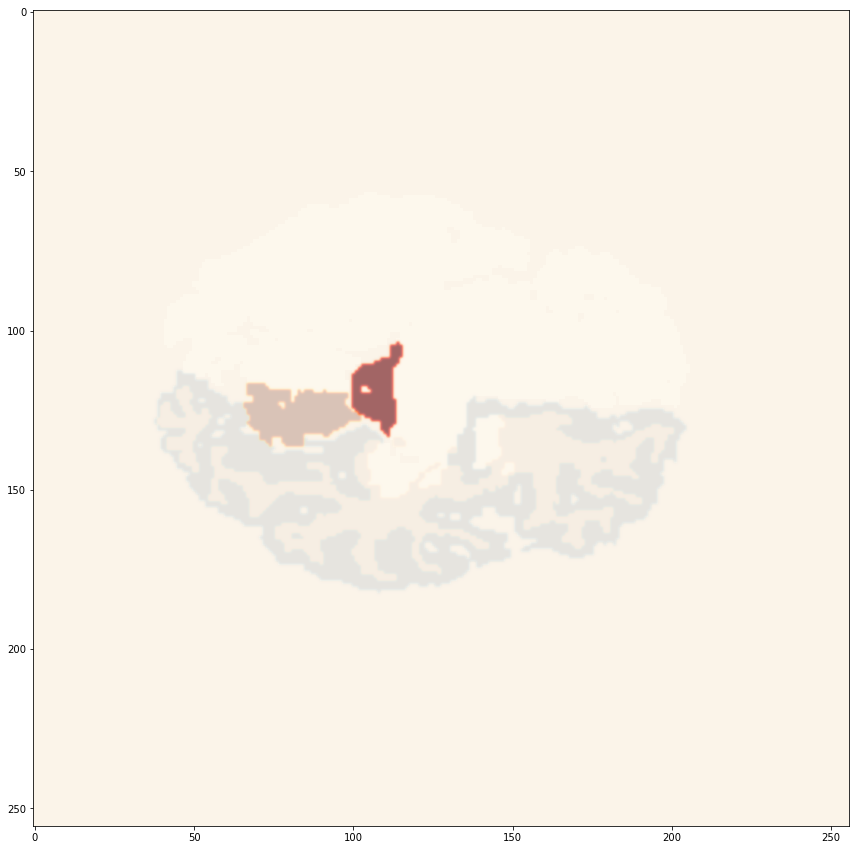

In [211]:
plt.figure(figsize = (15,15))


plt.imshow(inputs['y'][1,0,:,:].numpy(), cmap=plt.cm.Oranges, alpha = 1, interpolation='nearest')
plt.imshow(inputs['y'][1,1,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.7, interpolation='gaussian')
plt.imshow(inputs['y'][1,2,:,:].numpy(), cmap=plt.cm.Blues, alpha=.6, interpolation='gaussian')
plt.imshow(inputs['y'][1,6,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.6, interpolation='gaussian')
plt.imshow(inputs['y'][1,13,:,:].numpy(), cmap=plt.cm.Reds, alpha=.6, interpolation='gaussian')

# plt.imshow(inputs['y'][1,8,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,9,:,:].numpy(), cmap=plt.cm.YlOrRd, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,10,:,:].numpy(), cmap=plt.cm.OrRd, alpha=.6, interpolation='gaussian')

plt.show()





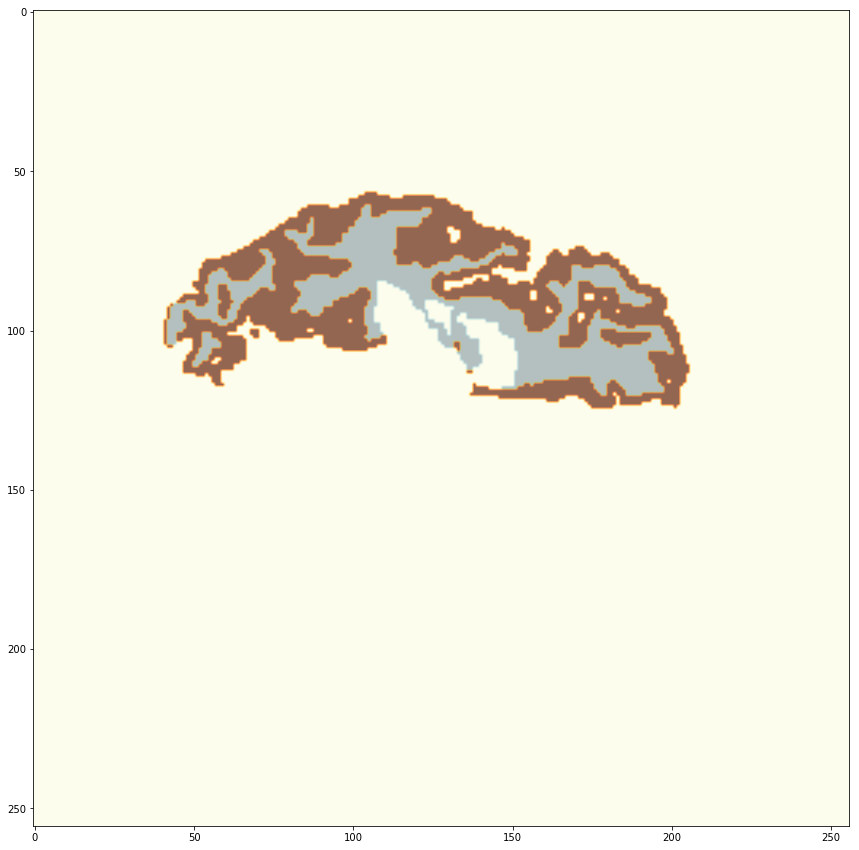

In [218]:
plt.figure(figsize = (15,15))

plt.imshow(inputs['y'][1,0,:,:].numpy(), cmap=plt.cm.Reds, alpha=.6, interpolation='nearest')


plt.imshow(inputs['y'][1,21,:,:].numpy(), cmap=plt.cm.Blues, alpha = 1, interpolation='bilinear')
plt.imshow(inputs['y'][1,22,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.7, interpolation='bilinear')
# plt.imshow(inputs['y'][1,2,:,:].numpy(), cmap=plt.cm.Blues, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,6,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,13,:,:].numpy(), cmap=plt.cm.Reds, alpha=.6, interpolation='gaussian')

# plt.imshow(inputs['y'][1,8,:,:].numpy(), cmap=plt.cm.YlOrBr, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,9,:,:].numpy(), cmap=plt.cm.YlOrRd, alpha=.6, interpolation='gaussian')
# plt.imshow(inputs['y'][1,10,:,:].numpy(), cmap=plt.cm.OrRd, alpha=.6, interpolation='gaussian')

plt.show()




